In [14]:
import pandas as pd
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.pyplot import figure
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


len(rows): 845


<Figure size 1440x800 with 0 Axes>

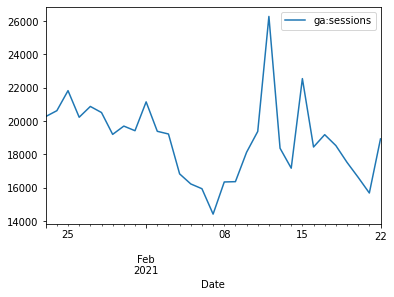

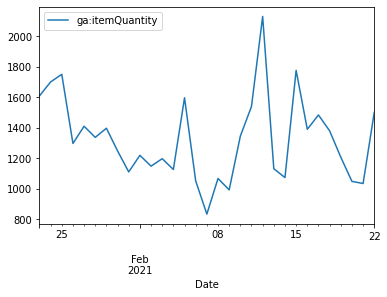

In [16]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = '/content/drive/MyDrive/Colab Notebooks/SEO_reporting/credentials/ga3.json'
VIEW_ID = '10414246'
def initialize_analyticsreporting():
    credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
    analytics = build('analyticsreporting', 'v4', credentials=credentials)
    return analytics
def get_report(analytics, pageTokenVar):
    return analytics.reports().batchGet(
        body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '31daysAgo', 'endDate': 'yesterday'}],
          'metrics': [{'expression': 'ga:sessions'}, {'expression': 'ga:itemQuantity'}], #, {'expression': 'ga:Goal completions'} didn't work.
          'dimensions': [{'name': 'ga:Date'}, {'name' :'ga:medium'}],
          'pageSize': 10000,
          'pageToken': pageTokenVar,
          'samplingLevel': 'LARGE'
        }]
      }
    ).execute()
def initialize_analyticsreporting():
    credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
    analytics = build('analyticsreporting', 'v4', credentials=credentials)
    return analytics
def handle_report(analytics,pagetoken,rows):  
    response = get_report(analytics, pagetoken)
    columnHeader = response.get("reports")[0].get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    pagetoken = response.get("reports")[0].get('nextPageToken', None)
    rowsNew = response.get("reports")[0].get('data', {}).get('rows', [])
    rows = rows + rowsNew    
    print("len(rows): " + str(len(rows)))
    if pagetoken != None:
        return handle_report(analytics,pagetoken,rows)
    else:
        nicerows=[]
        for row in rows:
            dic={}
            dimensions = row.get('dimensions', [])
            dateRangeValues = row.get('metrics', [])
            for header, dimension in zip(dimensionHeaders, dimensions):
                dic[header] = dimension
            for i, values in enumerate(dateRangeValues):
                for metric, value in zip(metricHeaders, values.get('values')):
                    if ',' in value or ',' in value:
                        dic[metric.get('name')] = float(value)
                    else:
                        dic[metric.get('name')] = int(value)
            nicerows.append(dic)
        return nicerows
def main():    
    analytics = initialize_analyticsreporting()
    global dfanalytics
    dfanalytics = []
    rows = []
    rows = handle_report(analytics,'0',rows)
    dfanalytics = pd.DataFrame(list(rows))
main()
#print(dfanalytics)
df = dfanalytics
df['Date'] = pd.to_datetime(df['ga:Date'])
df = df[df['ga:medium'] == 'organic']
df.rename(columns={"ga:sessions": "sessions", "ga:itemQuantity": "quantity"})
df.set_index('Date', inplace=True)
figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
sessions = df.iloc[: , [0, 2]].copy() 
sessions.drop(columns=['ga:Date'])
sessions.plot(kind='line')
quantity = df.iloc[: , [0, 3]].copy() 
quantity.drop(columns=['ga:Date'])
quantity.plot(kind='line')